In [3]:
# move into folder with the saved checkpoints
# need to run on fresh cell. idk why
cd aclImdb

SyntaxError: invalid syntax (<ipython-input-3-9a9dd9cd08fd>, line 2)

In [1]:
cd aclImdb

/misc/vlgscratch4/HeGroup/jlm10003/OOD/aclImdb


In [2]:
from tqdm import tqdm
from fairseq.models.roberta import RobertaModel
import torch
import pandas as pd
import numpy as np
import os
from bs4 import BeautifulSoup
import random
import gc
import pickle

from torch.nn.utils.rnn import pad_sequence
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
%%capture

# Load the model in fairseq
from fairseq.models.roberta import RobertaModel
import torch
roberta = RobertaModel.from_pretrained(
    'checkpoints',
    checkpoint_file='checkpoint_best.pt',
    data_name_or_path='IMDB-bin'
)
roberta.eval()  # disable dropout
roberta.cuda()

In [4]:
# pre-process and read in our data
imdb_dir = './train'

num_reviews = 500

reviews = []
for file in os.listdir(imdb_dir + '/neg'):
    #print(file)
    f = open(imdb_dir + '/neg/' + file)
    raw = f.read()
    reviews.append([raw, 'neg'])
    
for file in os.listdir(imdb_dir + '/pos'):
    #print(file)
    f = open(imdb_dir + '/pos/' + file)
    raw = f.read()
    reviews.append([raw, 'pos'])
    
import pandas as pd

imdb = pd.DataFrame(reviews, columns = ['text', 'sentiment'])
imdb.loc[imdb['sentiment'] == 'neg', 'sentiment'] = 0 
imdb.loc[imdb['sentiment'] == 'pos', 'sentiment'] = 1 
imdb

,text,sentiment
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [5]:
# import two examples from IMDB randomly, with same or different class condition
# sample from same class or different classes?
same_class = True
which_class = 0 # negative

if same_class:
    class_sub = imdb.loc[imdb.sentiment == which_class]
    df = class_sub.sample(n=2, replace = False)
else:
    df = imdb.groupby(['sentiment']).apply(lambda grp: grp.sample(n=1))
    
df

,text,sentiment
658,"Nu Image, UFO and others produce films for the...",0
6229,Miscasting happens. Susannah Yorke is a lumino...,0


In [6]:
imdb_tok1 = roberta.encode(df.iloc[0].text)
imdb_tok2 = roberta.encode(df.iloc[1].text)

# pad reviews to equal length
imdb1_enc = pad_sequence([imdb_tok1, imdb_tok2], padding_value = 1)[:,1]
imdb2_enc = pad_sequence([imdb_tok2, imdb_tok1], padding_value = 1)[:,1]

print('First Encoding')
print(imdb1_enc)
print('\n')
print('Second Encoding')
print(imdb2_enc)


First Encoding
tensor([    0,   448,  4473, 15374,  2594,     4, 10471, 25984, 25479,  1071,
           16,    10, 30878,  1827,   664,  7343, 15889,   241,     6,     8,
           69,   819,    16, 28462,   868,     4,   635,     6,  7393, 14841,
           16,  3518,     7,    28,  1718,     4,   735,    12, 29542,  1655,
          230,     4,  1699,  1326,     8, 41439,   101,    41,  4709,   212,
        43530,  1812,     4,  7343,    18, 10435, 11992,    16,    11,   357,
         3989,   328,    91,  8633,  6629,     8,  4543, 11278,    29,     6,
        39701,     8, 17081,     4,    91,  1326,   101,    41, 18884,    12,
          119,  6831,  7160,    54,    34,  1051,    39, 18884,    66,     7,
           28,  4406,  4490,   131,    52,   214,    45,  3911,    37,  4719,
           10,  1141,   740,  4628,    11,     5, 33093,   328,    20,   372,
          657,   527,  1326,   101,    10,   579,  2102,    12, 13738,  4306,
         5580, 12808,     4,   345,    16,   615,

In [7]:
# check padding worked
assert len(imdb1_enc) == len(imdb2_enc)
print(len(imdb1_enc))

# check equality of RoBERTA prediction and labeled sentiment (should be near 100% as this is training data)
label_fn = lambda label: roberta.task.label_dictionary.string(
    [label + roberta.task.label_dictionary.nspecial]
)

pred = label_fn(roberta.predict('imdb_head', imdb_tok1).argmax().item())
print(pred)
print(int(pred) == df.iloc[0].sentiment)

pred = label_fn(roberta.predict('imdb_head', imdb_tok2).argmax().item())
print(pred)
print(int(pred) == df.iloc[1].sentiment)

204
0
True
0
True


In [8]:
# Extract the last layer's features
imdb1_last_layer = roberta.extract_features(imdb1_enc)
imdb2_last_layer = roberta.extract_features(imdb2_enc)

In [9]:
# the first token is the CLS according to: https://github.com/pytorch/fairseq/issues/2317
imdb1_CLS = imdb1_last_layer[:,0,:]
imdb2_CLS = imdb2_last_layer[:,0,:]

In [17]:
# extrapolate between the total embeddings
lamb = -20
extra_last_layer = lamb * imdb1_last_layer + (1-lamb) * imdb2_last_layer
print(extra_last_layer)

# extrapolate between the CLS tokens
extra_CLS = lamb * imdb1_CLS + (1-lamb) * imdb2_CLS
print(extra_CLS)

# get prediction over entire extrapolated layer
logits = roberta.model.classification_heads['imdb_head'](extra_last_layer)
probs = torch.nn.functional.softmax(logits, dim=1)
pred = int(label_fn(probs.argmax().item()))
pred

tensor([[[  2.9559,   0.3791,   7.9527,  ...,   4.9536,  -6.7840,  -4.7422],
         [-11.7858, -13.1298,   2.5617,  ...,   5.3072,   0.4877,   4.4891],
         [ 15.4856, -13.4774,  19.0410,  ...,  -4.6541,   2.8916,  -4.0059],
         ...,
         [ -2.4430,   6.4508,  16.3761,  ...,  -5.9218,   1.9451,   7.0018],
         [  3.3232,   0.6366,  14.0104,  ...,  -1.8942,  -6.6068,  -9.6965],
         [ -5.0736,   3.0155,  16.7847,  ...,  -7.1872,  -3.9973,  -3.0262]]],
       device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 2.9559,  0.3791,  7.9527,  ...,  4.9536, -6.7840, -4.7422]],
       device='cuda:0', grad_fn=<AddBackward0>)


0

## Getting CLS embeddings from pre-trained RoBERTa model for visualization

In [18]:
# # initiate array we will fill
# embeds = np.zeros([1, 1024])

# for i, row in tqdm(imdb.iterrows(), total = imdb.shape[0]):
#     tok = roberta.encode(row.text)[0:512] # total number of tokens able to be taken in is 512. longest review is 3099 tokens
#     feats = roberta.extract_features(tok)
#     CLS = feats[:,0,:]
#     CLS = CLS.cpu().detach().numpy()

#     embeds = np.append(embeds, CLS, axis = 0)
    
#     # to clean up memory
#     del CLS
#     del feats
#     del tok
#     gc.collect()

# embeds = embeds[1:]
# with open('imdb_CLS_embeddings.pickle', 'wb') as handle:
#     pickle.dump(embeds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
file = open("imdb_CLS_embeddings.pickle",'rb')
embeds = pickle.load(file)
file.close()

embeds.shape

(25000, 1024)

In [20]:
# add extrapolated point 
arr1 = imdb1_CLS.cpu().detach().numpy()
arr2 = imdb2_CLS.cpu().detach().numpy()
arr_extra = extra_CLS.cpu().detach().numpy()

lab0 = df.iloc[0].sentiment
lab1 = df.iloc[1].sentiment
lab_extra = pred

embeds_extra = np.append(embeds, arr1, axis = 0)
embeds_extra = np.append(embeds_extra, arr2, axis = 0)
embeds_extra = np.append(embeds_extra, arr_extra, axis = 0)
embeds_extra.shape

(25003, 1024)

In [21]:
ys = imdb.sentiment
ys = ys.append(pd.Series([2, 2, 3]))
ys.shape

(25003,)

In [22]:
# # get cosine similarity between embeddings
# sims = cosine_similarity(embeds)
# sims
import seaborn as sns

pca = PCA(n_components=50)
pca = pca.fit(embeds_extra)
embed_pca = pca.transform(embeds_extra)

X_embedded = TSNE(n_components=2).fit_transform(embed_pca)

In [28]:
g

<AxesSubplot:>

In [144]:
gdf = pd.DataFrame(X_embedded)
gdf.columns = ['x', 'y']
gdf['label'] = np.array(ys)
gdf['style'] = gdf['label'] < 2
gdf['size'] = gdf['label']*500

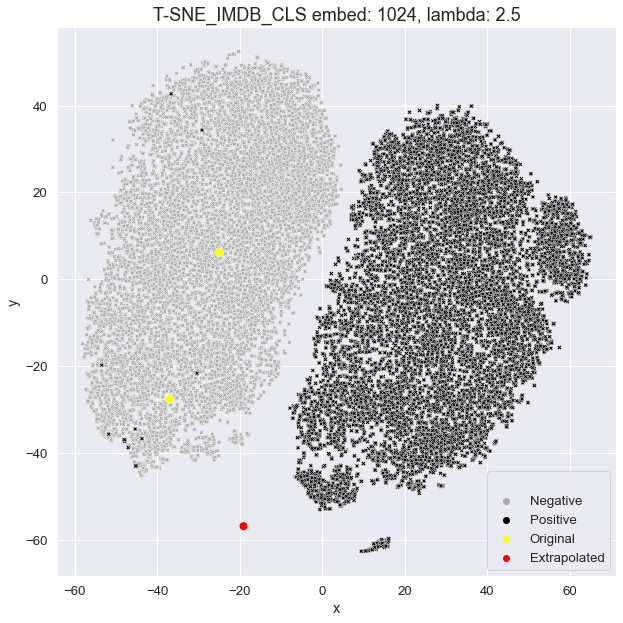

In [166]:
sns.set(rc={'figure.figsize':(9,9)})
sns.set(font_scale=1.2)
g = sns.scatterplot(data = gdf, x = 'x', y= 'y', hue = 'label', palette = ['darkgrey', 'black', 'yellow', 'red'], style = 'style',  size = 'style')
# replace labels

legend_labels, _= g.get_legend_handles_labels()
g.legend(legend_labels, ['', 'Negative', 'Positive', 'Original', 'Extrapolated'])

sns.set(font_scale=1.5)

plt.title("T-SNE_IMDB_CLS embed: 1024, lambda: 2.5")
plt.tight_layout()
plt.savefig('T-SNE_IMDB_CLS2.png', dpi=200)

In [68]:
# get logits for extrapolation
from fairseq.utils import log_softmax
logits = roberta.model.classification_heads['imdb_head'](extra_last_layer)
probs = torch.nn.functional.softmax(logits, dim=1)
pred = label_fn(probs.argmax().item())

print(pred)
print(int(pred) == df.iloc[0].sentiment)
print(int(pred) == df.iloc[1].sentiment)

0
True
True


In [59]:
torch.nn.functional.softmax(logits, dim=1)

tensor([[1.6650e-04, 9.9983e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## for preprocessing imdb data for finetuning according to : https://github.com/pytorch/fairseq/blob/master/examples/roberta/README.custom_classification.md


In [ ]:
# import argparse
# import os
# import random
# from glob import glob

# random.seed(0)

# def main(datadir):
#     for split in ['train', 'test']:
#         samples = []
#         for class_label in ['pos', 'neg']:
#             fnames = glob(os.path.join(datadir, split, class_label) + '/*.txt')
#             for fname in fnames:
#                 with open(fname) as fin:
#                     line = fin.readline()
#                     samples.append((line, 1 if class_label == 'pos' else 0))
#         random.shuffle(samples)
#         out_fname = 'train' if split == 'train' else 'dev'
#         f1 = open(os.path.join(datadir, out_fname + '.input0'), 'w')
#         f2 = open(os.path.join(datadir, out_fname + '.label'), 'w')
#         for sample in samples:
#             f1.write(sample[0] + '\n')
#             f2.write(str(sample[1]) + '\n')
#         f1.close()
#         f2.close()

# main('aclImdb')